# 6. Performing Human Evaluation

Welcome to the 6th session of the LLM tutorial!

In this session, we introduce that how to involve human evaluation during the model evaluation.

## 6.1 Introduction to Human Evaluation

In the previous tutorial, we explored **automatic metrics** used to evaluate model performance for specific tasks.

But have you considered these two important questions:

- Are there non-automatic metrics? What are they?
- How can we select the most suitable automatic metrics? (How do we evaluate the metrics themselves?)




### 6.1.1 Non-Automatic Metric
Let's start with a quick recap:

**Automatic metrics** are designed for evaluating models without human intervention.

As we discussed in the 5th tutorial, metrics like BLEU can compute evaluation scores automatically. However, automatic metrics are not always reliable, as they may:

- **Differ from human judgment.**
- **Fail to capture certain aspects of model performance.**

For example, **BLEU** is a pattern-matching metric based on n-gram precision. While it is useful for comparing surface-level matches, it overlooks **semantic information**, such as meaning and contextual accuracy.

To address these limitations, we often rely on **non-automatic metrics**, which involve human judgment. Human evaluation typically involves assigning scores (within a predefined range) or providing qualitative annotations based on various criteria.

In text generation tasks, for instance, human judgment may assess text quality based on factors such as:

- **Relevance**: Is the output relevant to the input?
- **Omission**: Are important details missing?
- **Fluency**: Is the text grammatically correct and natural?

Here's an example of a dataset for the text summarization task, which includes **human annotations**: [SummEval Dataset](https://huggingface.co/datasets/mteb/summeval?row=0).


### 6.1.2 Metric Selection
A single metric can only capture a limited set of aspects and cannot comprehensively evaluate a model's performance. This is why **no metric is perfect**.

The **ideal metric** is typically one that aligns closely with **human judgment**.

Thus, metric selection involves identifying an **automatic metric** that best correlates with human annotations. This ensures that the metric reflects the aspects that humans consider important.


### 6.1.3 Goal
In this session, we will learn how to **evaluate metrics** and identify the most suitable ones using **human evaluation**.

**Note**:
- Due to the high cost of human annotation, it is not feasible to evaluate all model outputs manually. Therefore, the practical approach is to find an automatic metric that **closely matches human judgment**.
- You might need GPU in the final pratical exercise (the tutorial code is runnable with CPU).



## 6.2 Environment Setup

In [1]:
! pip install -q datasets evaluate transformers
! pip install -q rouge_score sacrebleu
! pip install -q tqdm


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## 6.3 Load a Dataset for Summary Task

We will use the [SummEval](https://huggingface.co/datasets/mteb/summeval?row=0) dataset, which includes the original text, machine summary, human summary and the human annotation scores.

In [2]:
from datasets import load_dataset

data_summary = load_dataset("mteb/summeval")

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

### 6.3.1 Data Preview

Let's first take a look at the structure of the SummEval dataset. This will help you quickly understand the data and its relevance to the downstream task.

In [6]:
# Dataset Overview
data_summary

DatasetDict({
    test: Dataset({
        features: ['machine_summaries', 'human_summaries', 'relevance', 'coherence', 'fluency', 'consistency', 'text', 'id'],
        num_rows: 100
    })
})

In [14]:
# Log first 5 examples
data_summary['test'][0]['human_summaries']

["V. Stiviano must pay back $2.6 million in gifts from Donald Sterling. Sterling's wife claimed the ex-Clippers used the couple's money for the gifts. The items included a Ferrari, two Bentleys and a Range Rover.",
 'A player for a team has been under scrunity for money being earned while injured. The NBA is not pleased with these outcomes and this player has caused lots of controversy.',
 "Donald Sterling lost his NBA team amid racist comments. His former companion is set to pay back over $2.6 million to Sterling's wife through lawsuit. The case has been considered a victory for the Sterling family.",
 "Donald Sterling cheated with a mistress, Stiviano, who was sued by Sterling's wife. The mistress was blamed for Sterling spending over $2.6 million on her and ordered to pay it all back.",
 "Donald Sterling's mistress will have to pay Sterling's wife for many lavish gifts that Sterling bought for her.  V. Stiviano, the mistress, will have to pay pack $2,630,000 in restitution.  Sterlin

In [4]:
# Print the first instance of data
print(f"Length of the machine summaries: {len(data_summary['test'][0]['machine_summaries'])}")
print(f"Length of the human summaries: {len(data_summary['test'][0]['human_summaries'])}")
print(f"Length of the human annotaed (Relevance): {len(data_summary['test'][0]['relevance'])}")

Length of the machine summaries: 16
Length of the human summaries: 11
Length of the human annotaed (Relevance): 16


As we have observed below, the dataset consists of:

- `machine_summaries`: 16 summaries generated by various language models, waiting to be evaluated.
- `human_summaries`: 11 summaries written by human annotators, which serve as references.
- `relevance`, `coherence`, `fluency`, `consistency`: Scores annotated by human evaluators based on these four aspects.
- `text`: The source text to be summarized.
- `id`: The unique identifier for each text.

Overall, the downstream task is **summarization**. The goal is to condense the source text into a short, coherent paragraph.

For each source text, there are 16 machine-generated summaries and 11 human-written summaries, with human evaluators providing quality scores for the machine summaries.



## 6.4 Evaluate Machine Summaries

In this section, we will evaluate the machine-generated summaries using two widely adopted metrics: **BLEU** and **ROUGE**.

- **BLEU**: Originally designed for translation tasks, it measures n-gram overlap between the generated text and the reference text.
- **ROUGE**: Specifically designed for summarization tasks, it evaluates the overlap of n-grams, as well as sequences of words, between the generated and reference summaries.

Given the nature of the task, it is intuitive to expect that **ROUGE** will perform better than **BLEU** in evaluating summarization quality.


### ROUGE


In [15]:
from rouge_score import rouge_scorer
from tqdm import tqdm

def postprocess_text(data):
    # Sometimes we need a postprocess
    machine_summaries = []
    human_summaries = []
    for item in data['test']:
        machine_summaries.extend(item['machine_summaries'])  # Extend to handle multiple machine summaries
        human_summaries.extend([item['human_summaries']] * len(item['machine_summaries']))  # Repeat human references

    return machine_summaries, human_summaries

def compute_rouge_metrics(data):
    machine_summaries, human_summaries = postprocess_text(data)
    print(f"Length of the machine summaries: {len(machine_summaries)}")
    print(f"Length of the human summaries: {len(human_summaries)}")
    print(f"Length of the human summaries 0: {len(human_summaries[0])}")
    print(f"Machine summaries: {machine_summaries[0]}")
    print(f"Human summaries: {human_summaries[0]}")

    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Compute instance-level ROUGE scores
    instance_scores = []
    for i in tqdm(range(len(machine_summaries))):
        # Compute ROUGE for each machine summary against multiple human references
        scores = [scorer.score(machine_summaries[i], ref) for ref in human_summaries[i]]

        # Aggregate scores across all references (e.g., take the max, mean, or any other method)
        aggregated_scores = {
            'rouge1': max(s['rouge1'].fmeasure for s in scores),
            'rouge2': max(s['rouge2'].fmeasure for s in scores),
            'rougeL': max(s['rougeL'].fmeasure for s in scores)
        }
        instance_scores.append(aggregated_scores)

    return instance_scores

In [16]:
rouge_scores = compute_rouge_metrics(data_summary)

Length of the machine summaries: 1600
Length of the human summaries: 1600
Length of the human summaries 0: 11
Machine summaries: donald sterling , nba team last year . sterling 's wife sued for $ 2.6 million in gifts . sterling says he is the former female companion who has lost the . sterling has ordered v. stiviano to pay back $ 2.6 m in gifts after his wife sued . sterling also includes a $ 391 easter bunny costume , $ 299 and a $ 299 .
Human summaries: ["V. Stiviano must pay back $2.6 million in gifts from Donald Sterling. Sterling's wife claimed the ex-Clippers used the couple's money for the gifts. The items included a Ferrari, two Bentleys and a Range Rover.", 'A player for a team has been under scrunity for money being earned while injured. The NBA is not pleased with these outcomes and this player has caused lots of controversy.', "Donald Sterling lost his NBA team amid racist comments. His former companion is set to pay back over $2.6 million to Sterling's wife through lawsui

100%|██████████| 1600/1600 [00:31<00:00, 50.44it/s]


In [17]:
# show one rouge score result for the first instance
rouge_scores[0]

{'rouge1': 0.5263157894736842,
 'rouge2': 0.2553191489361702,
 'rougeL': 0.29508196721311475}

### BLEU

In [18]:
import sacrebleu

def compute_bleu_instance_scores(data):
    machine_summaries, human_summaries = postprocess_text(data)
    print(f"Number of machine summaries: {len(machine_summaries)}")
    print(f"Number of human summaries: {len(human_summaries)}")
    print(f"Example machine summary: {machine_summaries[0]}")
    print(f"Example human references: {human_summaries[0]}")

    # Compute BLEU scores for each instance
    instance_scores = []
    for i in tqdm(range(len(machine_summaries))):
        # Compute BLEU for each machine summary and its corresponding human references
        bleu = sacrebleu.sentence_bleu(machine_summaries[i], human_summaries[i])
        instance_scores.append({'bleu': bleu.score})

    return instance_scores

In [19]:
bleu_scores = compute_bleu_instance_scores(data_summary)

Number of machine summaries: 1600
Number of human summaries: 1600
Example machine summary: donald sterling , nba team last year . sterling 's wife sued for $ 2.6 million in gifts . sterling says he is the former female companion who has lost the . sterling has ordered v. stiviano to pay back $ 2.6 m in gifts after his wife sued . sterling also includes a $ 391 easter bunny costume , $ 299 and a $ 299 .
Example human references: ["V. Stiviano must pay back $2.6 million in gifts from Donald Sterling. Sterling's wife claimed the ex-Clippers used the couple's money for the gifts. The items included a Ferrari, two Bentleys and a Range Rover.", 'A player for a team has been under scrunity for money being earned while injured. The NBA is not pleased with these outcomes and this player has caused lots of controversy.', "Donald Sterling lost his NBA team amid racist comments. His former companion is set to pay back over $2.6 million to Sterling's wife through lawsuit. The case has been consider

100%|██████████| 1600/1600 [00:03<00:00, 467.26it/s]


In [20]:
# show one bleu score result for the first instance
bleu_scores[0]

{'bleu': 17.03878880147131}

## 6.5 Compare with Human Evaluaion

In this section, we will compare metrics scores(e.g. BLEU, ROUGE) with the human annotated scores by computing correlation.






### 6.5.1 Correlation Levels
There are generally two levels of correlation scores, each focusing on different evaluation perspectives:

- **System-level correlation**:  At this level, predictions generated by the same system (e.g., a language model) are grouped together. The mean score is computed for each group, and correlation is calculated based on these group averages.
- **Instance-level correlation**:
At this level, all predictions are treated independently, regardless of their source. Correlation is computed based on individual instance scores.

**Question**: Why System-level?
- Closer to the main purpose. (Usually we use metric to compare the systems)
- Reduce noise from individual instances.

In [21]:
# Extract the human annotated score from the original dataset
def extract_human_scores(data_summary):
    human_scores = []
    for item in data_summary['test']:
        # Attention, each item is a group of 16 instances
        for j in range(len(item['relevance'])):
            score_dict = {
                'relevance': item['relevance'][j],
                'coherence': item['coherence'][j],
                'fluency': item['fluency'][j],
                'consistency': item['consistency'][j],
            }

            # Append score_dict into human_scores
            human_scores.append(score_dict)

    return human_scores

In [22]:
human_scores = extract_human_scores(data_summary)

In [23]:
def merge_metric_human_score(metric_name, metric_scores, human_scores):
    '''
    This function is used to merge scores which are computed by a specific metric into the human scores for faciliate next computations.

    Inputs:
        - metric_name: string
        - metric_scores: a list of scores
        - human_scores: a list of score dictionary which contains human annotations
        Note. We suppose that the data in the inputs are in the same order on the instance level.

    Output:
        - all_scores: a list of score dictionary including metric scores
    '''
    # Assert that metric_scores and human_scores have the same length
    assert len(metric_scores) == len(human_scores), (
        f"Length mismatch: metric_scores has {len(metric_scores)} elements, "
        f"while human_scores has {len(human_scores)} elements."
    )

    # Merge the metric scores into the human scores
    for i, item in enumerate(human_scores):
        assert isinstance(item, dict), f"Expected human_scores[{i}] to be a dictionary, got {type(item)}."
        # Flat human scores into instance-level
        human_scores[i][metric_name] = metric_scores[i]



    return human_scores

In [24]:
def make_bleu_rouge_score_list(bleu_scores, rouge_scores):
    assert len(bleu_scores) == len(rouge_scores), (
        f"Length mismatch: bleu scores has {len(bleu_scores)} elements, "
        f"while rouge_scores has {len(rouge_scores)} elements."
    )

    bleu_list, rouge1_list, rouge2_list, rougeL_list = [], [], [], []
    for i, _ in enumerate(bleu_scores):
        bleu_list.append(bleu_scores[i]['bleu'])
        rouge1_list.append(rouge_scores[i]['rouge1'])
        rouge2_list.append(rouge_scores[i]['rouge2'])
        rougeL_list.append(rouge_scores[i]['rougeL'])

    return bleu_list, rouge1_list, rouge2_list, rougeL_list

In [25]:
bleu_list, rouge1_scores, rouge2_scores, rougeL_scores = make_bleu_rouge_score_list(bleu_scores, rouge_scores)
# merge bleu, rouge scores to human scores
human_bleu_scores = merge_metric_human_score('bleu', bleu_list, human_scores)
human_bleu_rouge_scores = merge_metric_human_score('rouge1', rouge1_scores, human_bleu_scores)
human_bleu_rouge_scores = merge_metric_human_score('rouge2', rouge2_scores, human_bleu_rouge_scores)
human_bleu_rouge_scores = merge_metric_human_score('rougeL', rougeL_scores, human_bleu_rouge_scores)

In [26]:
# Check whether we have put all scores into one instance
human_bleu_rouge_scores[0]

{'relevance': 1.6666666666666667,
 'coherence': 1.3333333333333333,
 'fluency': 1.0,
 'consistency': 1.0,
 'bleu': 17.03878880147131,
 'rouge1': 0.5263157894736842,
 'rouge2': 0.2553191489361702,
 'rougeL': 0.29508196721311475}

### 6.5.2 System-level

In [27]:
from scipy.stats import pearsonr
from collections import defaultdict

def compute_system_level_score(human_bleu_rouge_scores):
    '''
    This function is used to compute the correlation between automatic metrics and human annotations on a system level.

    ====IMPORTANT====
    As the summaries are generated by 16 LLMs, we consider each LLM as a system.
    It means the i-th and the (i+16)-th elements are generated by the same system.
    '''

    num_system = 16
    assert len(human_bleu_rouge_scores) % num_system == 0, (
        "The number of scores is not divisible by the number of systems. "
        "Please check the input data."
    )

    # Prepare average scores for each system
    system_scores = defaultdict(lambda: defaultdict(list))
    num_instances_per_system = len(human_bleu_rouge_scores) // num_system

    for i in range(num_system):
        for j in range(num_instances_per_system):
            instance_idx = i + num_system * j
            instance_scores = human_bleu_rouge_scores[instance_idx]

            # Group scores by system
            for key, value in instance_scores.items():
                system_scores[i][key].append(value)

    # Compute mean scores for each system
    averaged_system_scores = {
        system_id: {metric: sum(values) / len(values) for metric, values in metrics.items()}
        for system_id, metrics in system_scores.items()
    }

    # Extract system-level scores for metrics and human annotations
    metric_names = ["bleu", "rouge1", "rouge2", "rougeL"]
    human_metrics = ["relevance", "coherence", "fluency", "consistency"]

    system_level_metrics = {metric: [] for metric in metric_names}
    system_level_human = {metric: [] for metric in human_metrics}

    for system_id, scores in averaged_system_scores.items():
        for metric in metric_names:
            system_level_metrics[metric].append(scores[metric])
        for human_metric in human_metrics:
            system_level_human[human_metric].append(scores[human_metric])

    # Compute Pearson correlations
    correlations = {}
    for metric in metric_names:
        correlations[metric] = {}
        for human_metric in human_metrics:
            corr, _ = pearsonr(system_level_metrics[metric], system_level_human[human_metric])
            correlations[metric][human_metric] = corr

    return correlations

In [29]:
! pip install seaborn -q


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def show_correlation(correlations, display_table=True):
    """
    This function formats and displays the correlation results in a readable table.

    Args:
        - correlations (dict): The dictionary containing correlation results.
        - display_table (bool): Whether to display the table in the console (default: True).
    """
    # Convert the nested dictionary into a DataFrame for better visualization
    df = pd.DataFrame(correlations).T

    if display_table:
        print("\nCorrelation Results (Metric vs Human Evaluation):")
        print(df)

    # Return the DataFrame for further usage if needed
    return df

def plot_heatmap(df):
    # Create a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'Correlation Coefficient'})
    plt.title("Correlation Heatmap: Metrics vs Human Evaluation", fontsize=14)
    plt.xlabel("Human Evaluation Metrics", fontsize=12)
    plt.ylabel("Automatic Metrics", fontsize=12)
    plt.tight_layout()
    plt.show()

In [31]:
# Compute correlations
correlations = compute_system_level_score(human_bleu_rouge_scores)

# Show correlation
df = show_correlation(correlations, display_table=True)


Correlation Results (Metric vs Human Evaluation):
        relevance  coherence   fluency  consistency
bleu     0.462037   0.492900  0.232538     0.175253
rouge1   0.680887   0.276226  0.654119     0.688877
rouge2   0.662387   0.283968  0.636789     0.663887
rougeL   0.696694   0.475718  0.644506     0.615390


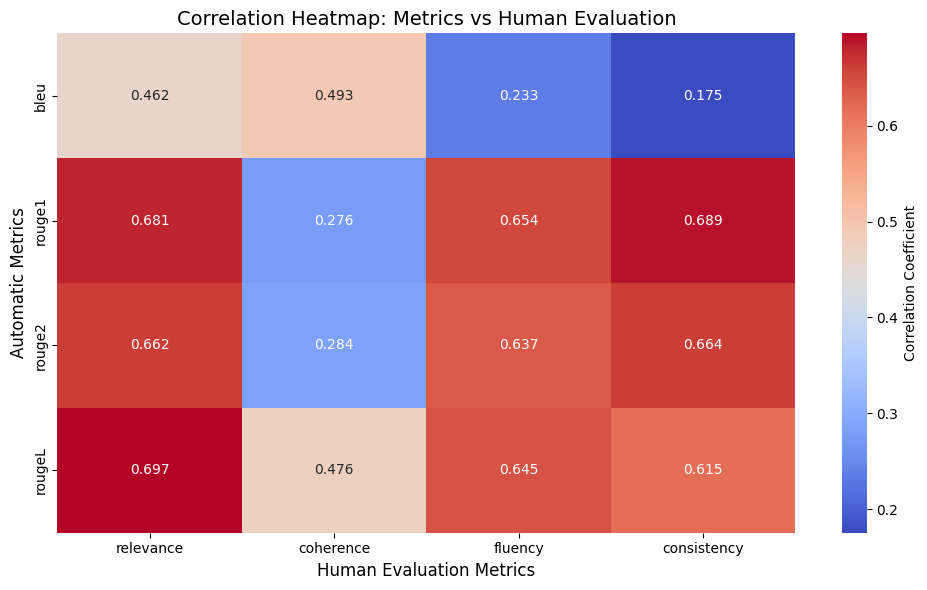

In [32]:
# Visualize the results in heatmap
plot_heatmap(df)

### 6.5.3 Instance-level

The operations are similar to on system-level.

In [33]:
def compute_instance_level_score(human_bleu_rouge_scores):
    '''
    This function computes instance-level correlation between automatic metrics
    (e.g., BLEU, ROUGE) and human evaluation metrics (e.g., relevance, fluency).

    Inputs:
        - human_bleu_rouge_scores: List of dictionaries. Each dictionary contains
          automatic metric scores (e.g., 'bleu', 'rouge1') and human evaluation scores
          (e.g., 'relevance', 'fluency') for a single instance.

    Output:
        - correlations: Dictionary of correlation results between each automatic metric
          and each human evaluation metric.
    '''
    # Define metric names
    metric_names = ["bleu", "rouge1", "rouge2", "rougeL"]
    human_metrics = ["relevance", "coherence", "fluency", "consistency"]

    # Prepare lists to hold metric and human evaluation scores
    metric_scores = {metric: [] for metric in metric_names}
    human_scores = {human_metric: [] for human_metric in human_metrics}

    # Populate the lists from the input data
    for instance in human_bleu_rouge_scores:
        for metric in metric_names:
            metric_scores[metric].append(instance[metric])
        for human_metric in human_metrics:
            human_scores[human_metric].append(instance[human_metric])

    # Compute Pearson correlations
    correlations = {}
    for metric in metric_names:
        correlations[metric] = {}
        for human_metric in human_metrics:
            # Compute Pearson correlation between the two lists
            corr, _ = pearsonr(metric_scores[metric], human_scores[human_metric])
            correlations[metric][human_metric] = corr

    return correlations


In [34]:
# Compute correlations
correlations_instance = compute_instance_level_score(human_bleu_rouge_scores)

# Show instance-level instance
df_instance = show_correlation(correlations_instance, display_table=True)


Correlation Results (Metric vs Human Evaluation):
        relevance  coherence   fluency  consistency
bleu     0.289784   0.249679  0.139040     0.117483
rouge1   0.349740   0.224760  0.171171     0.212273
rouge2   0.239955   0.155816  0.123316     0.167018
rougeL   0.255646   0.206109  0.134816     0.173601


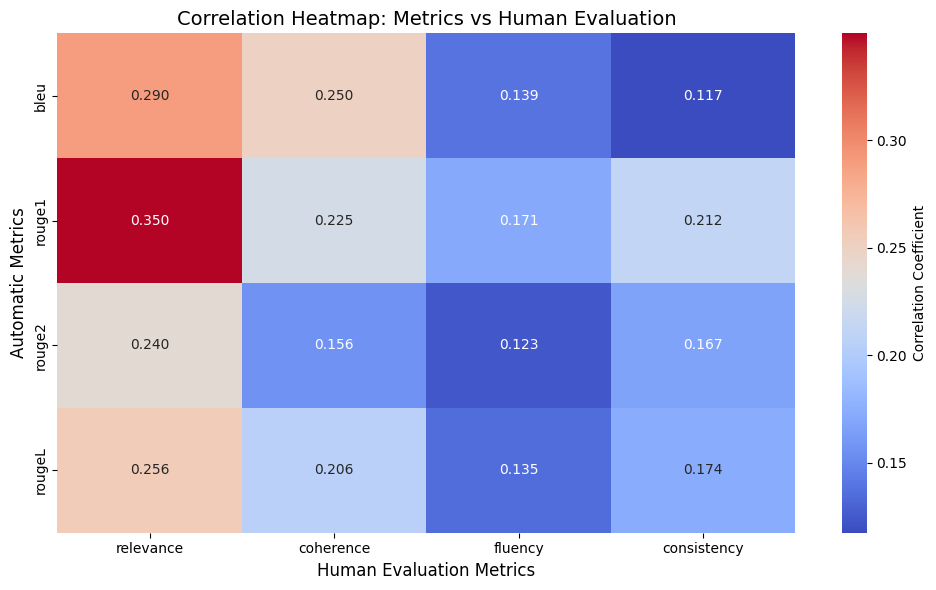

In [35]:
# Plot heatmap
plot_heatmap(df_instance)

## 6.6 Conlusion







### 6.6.1 Experiment Result
From the results above, we can observe that ROUGE aligns more closely with human judgments at the system level. This finding supports our hypothesis that **ROUGE is a more reliable metric than BLEU for summarization tasks**.

However, at the instance level, the correlation scores are notably low for all automatic metrics. This highlights the difficulty of achieving consistent scores at the instance level, where even human annotators sometimes disagree with each other. This disagreement further demonstrates the inherent challenges of evaluating text quality on such a fine-grained scale.

### 6.6.2 Annotating

English: http://annotatehost.loria.fr:9006/?PROLIFIC_PID=login

https://annotatehost.loria.fr:9006/?PROLIFIC_PID=oyetunji.abioye
Arabic: http://annotatehost.loria.fr:9001/?PROLIFIC_PID=login
French: http://annotatehost.loria.fr:9002/?PROLIFIC_PID=login
Russian: http://annotatehost.loria.fr:9003/?PROLIFIC_PID=login
Spanish: http://annotatehost.loria.fr:9004/?PROLIFIC_PID=login
Chinese: http://annotatehost.loria.fr:9005/?PROLIFIC_PID=login

 To access the link, replace login by firstname.lastname


####  6.6.3  Annotation platforms

As the saying goes, “time is money”—and human annotations are certainly costly in both time and resources. Because of this, we often limit human annotations to small, carefully chosen test sets.

But here's the silver lining: the demand for annotations has given rise to a new profession—Human Annotator! If labeling tasks sound like your cup of tea (and you'd like to earn a few bucks along the way), here are two great places to start:
- [Prolific.](https://www.prolific.com/)
- [Amazon Mechanical Turk.](https://www.mturk.com/)

## 6.7 Exercise

**Hang in there—this is the final exercise!**

Through the previous code, you've seen how to use human evaluation to select reliable automatic metrics. Now, it's your turn to **explore metrics** beyond BLEU and ROUGE and compute their correlation with human evaluations to demonstrate their feasibility and reliability.

**Suggestions:**
- You can continue working with the same task and dataset for this exercise.
- There's no need to start from scratch. Carefully review the provided functions and feel free to reuse or modify them as needed.
- Before diving into a new metric, I recommend taking a moment to understand its design principles and objectives (e.g., does it support summarization tasks?).

**Here's a checklist to guide your exploration:**
- Load the dataset.
- Compute scores using your chosen metric.
- Extract human evaluation scores.
- (Optional but recommended) Combine the automatic metric scores with human evaluation scores into an instance-level dataset.
- Compute both system-level and instance-level Pearson correlation scores.
- Visualize your results and plot a heatmap.

Good luck, and have fun exploring new metrics! 🚀